In [63]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
import matplotlib.font_manager as fm

# 讀取 CSV 文件
df = pd.read_csv('/Users/ccit0915/Desktop/kaggle/房價回歸預測/train_df.csv', encoding='utf-8')
df

,Unnamed: 0,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,0,1,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,...,0,0,0,0,0,2,2008,WD,Normal,208500
1,1,2,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,...,0,0,0,0,0,5,2007,WD,Normal,181500
2,2,3,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,...,0,0,0,0,0,9,2008,WD,Normal,223500
3,3,4,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,...,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,4,5,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,...,0,0,0,0,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1455,1456,60,RL,62.0,7917,Pave,Reg,Lvl,AllPub,...,0,0,0,0,0,8,2007,WD,Normal,175000
1456,1456,1457,20,RL,85.0,13175,Pave,Reg,Lvl,AllPub,...,0,0,0,0,0,2,2010,WD,Normal,210000
1457,1457,1458,70,RL,66.0,9042,Pave,Reg,Lvl,AllPub,...,0,0,0,0,2500,5,2010,WD,Normal,266500
1458,1458,1459,20,RL,68.0,9717,Pave,Reg,Lvl,AllPub,...,112,0,0,0,0,4,2010,WD,Normal,142125


In [65]:
missing_values = df.isnull().sum().sort_values(ascending=False)
missing_values = missing_values[missing_values > 0]
print(missing_values)

MasVnrType    872
MasVnrArea      8
dtype: int64


In [67]:
# 計算 MasVnrType 的眾數（最常見的類別）
mas_vnr_mode = df['MasVnrType'].mode()[0]

# 計算 MasVnrArea 的平均值（去除 NaN）
mas_vnr_mean = df['MasVnrArea'].mean()

# 條件 1: 如果 MasVnrType 是 NaN，但 MasVnrArea 有值，則補上眾數
df.loc[df['MasVnrType'].isna() & df['MasVnrArea'].notna(), 'MasVnrType'] = mas_vnr_mode

# 條件 2: 如果 MasVnrType 是 NaN，且 MasVnrArea 也是 NaN，則 MasVnrType 補 'None'
df.loc[df['MasVnrType'].isna() & df['MasVnrArea'].isna(), 'MasVnrType'] = 'None'

# 條件 3: 如果 MasVnrArea 是 NaN，但 MasVnrType 有類別，則補上該欄的均值
df.loc[df['MasVnrArea'].isna() & df['MasVnrType'].notna(), 'MasVnrArea'] = mas_vnr_mean

In [69]:
missing_values = df.isnull().sum().sort_values(ascending=False)
missing_values = missing_values[missing_values > 0]
print(missing_values)

Series([], dtype: int64)


In [71]:
print(df['MasVnrType'].unique())  # 列出所有獨特的類別
print(df['MasVnrType'].value_counts())  # 計算每個類別的出現次數

['BrkFace' 'Stone' 'BrkCmn' 'None']
MasVnrType
BrkFace    1309
Stone       128
BrkCmn       15
None          8
Name: count, dtype: int64


In [73]:
categorical_cols = df.select_dtypes(include=['object']).columns
print(categorical_cols)

Index(['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'SaleType', 'SaleCondition'],
      dtype='object')


In [75]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder

# 確保欄位名稱無多餘空格
df.columns = df.columns.str.strip()

# 分離特徵變數與目標變數
X = df.drop(columns=['SalePrice'])
y = df['SalePrice']

# 分割訓練集與測試集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# **步驟 1: 動態獲取 ordinal_cols 的類別**
ordinal_cols = [
    'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
    'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'KitchenQual', 'FireplaceQu',
    'GarageFinish', 'GarageQual', 'GarageCond'
]

# 根據數據動態建立每個變數的類別順序
ordinal_categories = {col: sorted(X_train[col].dropna().unique().tolist()) for col in ordinal_cols}

# **步驟 2: Ordinal Encoding**
ordinal_encoder = OrdinalEncoder(categories=list(ordinal_categories.values()),
                                 handle_unknown='use_encoded_value',
                                 unknown_value=-1)

# 執行編碼
X_train[ordinal_cols] = ordinal_encoder.fit_transform(X_train[ordinal_cols])
X_test[ordinal_cols] = ordinal_encoder.transform(X_test[ordinal_cols])

# **步驟 3: 剩餘類別變數進行頻率編碼**
categorical_cols = X_train.select_dtypes(include=['object']).columns.tolist()
categorical_cols = [col for col in categorical_cols if col not in ordinal_cols]  # 移除已編碼的欄位

# 計算頻率並映射
for col in categorical_cols:
    freq_map = X_train[col].value_counts(normalize=True)  # 計算訓練集中每個類別的頻率
    X_train[col] = X_train[col].map(freq_map)
    X_test[col] = X_test[col].map(freq_map)  # 測試集應用相同映射

# 測試集中可能有 unseen 類別，填補 NaN 為 0
X_test[categorical_cols] = X_test[categorical_cols].fillna(0)

# **檢查是否還有非數值欄位**
non_numeric_X_train = X_train.select_dtypes(exclude=['number']).columns
non_numeric_X_test = X_test.select_dtypes(exclude=['number']).columns

# **確認目標變數是否數值型**
y_train_df = pd.DataFrame(y_train)
y_test_df = pd.DataFrame(y_test)
non_numeric_y_train = y_train_df.select_dtypes(exclude=['number']).columns
non_numeric_y_test = y_test_df.select_dtypes(exclude=['number']).columns

# **輸出結果**
print("X_train 中的非數值欄位:", non_numeric_X_train.tolist())
print("X_test 中的非數值欄位:", non_numeric_X_test.tolist())
print("y_train 中的非數值欄位:", non_numeric_y_train.tolist())
print("y_test 中的非數值欄位:", non_numeric_y_test.tolist())

X_train 中的非數值欄位: []
X_test 中的非數值欄位: []
y_train 中的非數值欄位: []
y_test 中的非數值欄位: []


In [31]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from pytorch_tabnet.tab_model import TabNetRegressor
import numpy as np
import torch

y_train = y_train.to_numpy().reshape(-1, 1)
y_test = y_test.to_numpy().reshape(-1, 1)

# 設定隨機種子
torch.manual_seed(42)

X_train_np = X_train.to_numpy()  # 或 X_train.values
X_test_np = X_test.to_numpy()    # 或 X_test.values

# 建立 TabNet 模型
tabnet_model = TabNetRegressor(
    n_d=8, n_a=8, n_steps=3, gamma=1.5, lambda_sparse=0.0001,
    optimizer_fn=torch.optim.Adam,  # 這裡改為使用 torch.optim.Adam
    optimizer_params=dict(lr=2e-2),
    mask_type="sparsemax"
)
# 訓練 TabNet 模型
tabnet_model.fit(X_train_np, y_train, max_epochs=100, batch_size=1024, virtual_batch_size=128, num_workers=0, drop_last=True)

# 預測
y_pred_tabnet = tabnet_model.predict(X_test_np)

# 評估模型表現
mse_tabnet = mean_squared_error(y_test, y_pred_tabnet)
mae_tabnet = mean_absolute_error(y_test, y_pred_tabnet)
rmse_tabnet = np.sqrt(mse_tabnet)
r2_tabnet = r2_score(y_test, y_pred_tabnet)

# 輸出評估指標
print(f"TabNet 測試 MSE: {mse_tabnet}")
print(f"TabNet 測試 RMSE: {rmse_tabnet}")
print(f"TabNet 測試 MAE: {mae_tabnet}")
print(f"TabNet 測試 R²: {r2_tabnet}")

/Users/ccit0915/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/Users/ccit0915/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 39022243840.0|  0:00:00s
epoch 1  | loss: 38376808448.0|  0:00:00s
epoch 2  | loss: 39393533952.0|  0:00:00s
epoch 3  | loss: 39224184832.0|  0:00:00s
epoch 4  | loss: 39684485120.0|  0:00:00s
epoch 5  | loss: 38985261056.0|  0:00:00s
epoch 6  | loss: 38662758400.0|  0:00:00s
epoch 7  | loss: 38634004480.0|  0:00:00s
epoch 8  | loss: 38365978624.0|  0:00:00s
epoch 9  | loss: 38726877184.0|  0:00:00s
epoch 10 | loss: 38607233024.0|  0:00:00s
epoch 11 | loss: 38843609088.0|  0:00:00s
epoch 12 | loss: 39591452672.0|  0:00:00s
epoch 13 | loss: 38733996032.0|  0:00:00s
epoch 14 | loss: 39159963648.0|  0:00:00s
epoch 15 | loss: 38368604160.0|  0:00:00s
epoch 16 | loss: 38863663104.0|  0:00:00s
epoch 17 | loss: 38956232704.0|  0:00:00s
epoch 18 | loss: 39951024128.0|  0:00:00s
epoch 19 | loss: 39068270592.0|  0:00:00s
epoch 20 | loss: 39281442816.0|  0:00:00s
epoch 21 | loss: 38664921088.0|  0:00:00s
epoch 22 | loss: 38476783616.0|  0:00:00s
epoch 23 | loss: 38398992384.0|  0

In [77]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error


# 建立隨機森林模型
rf_model = RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42)

# 訓練模型
rf_model.fit(X_train, y_train)

# 預測
y_pred = rf_model.predict(X_test)

# 評估模型表現
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# 輸出評估指標
print(f"測試 MSE: {mse}")
print(f"測試 RMSE: {rmse}")
print(f"測試 MAE: {mae}")
print(f"測試 R²: {r2}")

測試 MSE: 826011126.0808233
測試 RMSE: 28740.409288679646
測試 MAE: 17724.71112435259
測試 R²: 0.8923108217605077


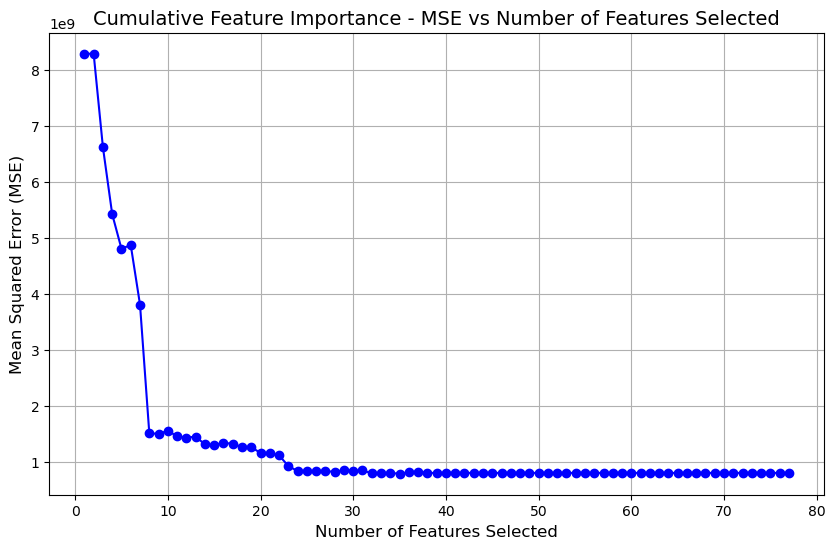

In [59]:
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error

# 初始化隨機森林回歸模型
rf_model = RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42)

# 訓練模型並使用RFE
rfe = RFE(estimator=rf_model)
rfe.fit(X_train, y_train)

# 儲存每個步驟的模型表現（MSE或R²）
mse_values = []

# 遍歷每個特徵數量
for i in range(1, len(X_train.columns) + 1):
    selected_features = X_train.columns[rfe.support_][:i]
    X_train_rfe = X_train[selected_features]
    X_test_rfe = X_test[selected_features]
    
    # 訓練模型
    rf_model.fit(X_train_rfe, y_train)
    
    # 預測並計算MSE
    y_pred = rf_model.predict(X_test_rfe)
    mse = mean_squared_error(y_test, y_pred)
    mse_values.append(mse)

# 繪製特徵數量與模型MSE的關係
plt.figure(figsize=(10,6))
plt.plot(range(1, len(X_train.columns) + 1), mse_values, marker='o', linestyle='-', color='b')
plt.title("Cumulative Feature Importance - MSE vs Number of Features Selected", fontsize=14)
plt.xlabel("Number of Features Selected", fontsize=12)
plt.ylabel("Mean Squared Error (MSE)", fontsize=12)
plt.grid(True)
plt.show()

In [79]:
from sklearn.inspection import permutation_importance
import numpy as np

# 確保 X_test 的特徵名稱與訓練時相同
X_test = X_test[X_train.columns]

# 計算 PFI
pfi_result = permutation_importance(rf_model, X_test, y_test, n_repeats=10, random_state=42)

# 取得重要性排名
pfi_importance = pfi_result.importances_mean
pfi_features = X_test.columns[np.argsort(-pfi_importance)[:8]]

print("PFI 方法選出的前 8 大特徵：")
print(pfi_features)

PFI 方法選出的前 8 大特徵：
Index(['OverallQual', 'GrLivArea', '2ndFlrSF', 'TotalBsmtSF', '1stFlrSF',
       'BsmtFinSF1', 'GarageCars', 'LotArea'],
      dtype='object')


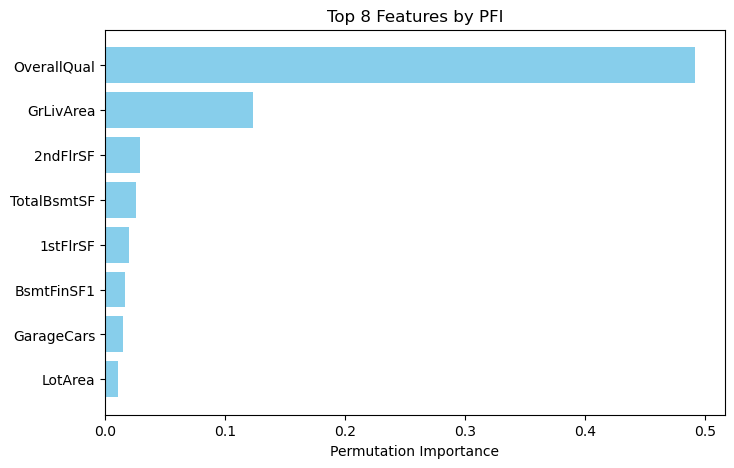

In [81]:
import matplotlib.pyplot as plt

sorted_idx = np.argsort(pfi_importance)[::-1]  # 由高到低排序
plt.figure(figsize=(8, 5))
plt.barh(X_test.columns[sorted_idx][:8], pfi_importance[sorted_idx][:8], color='skyblue')
plt.xlabel("Permutation Importance")
plt.title("Top 8 Features by PFI")
plt.gca().invert_yaxis()  # 讓排名第一的特徵在最上方
plt.show()

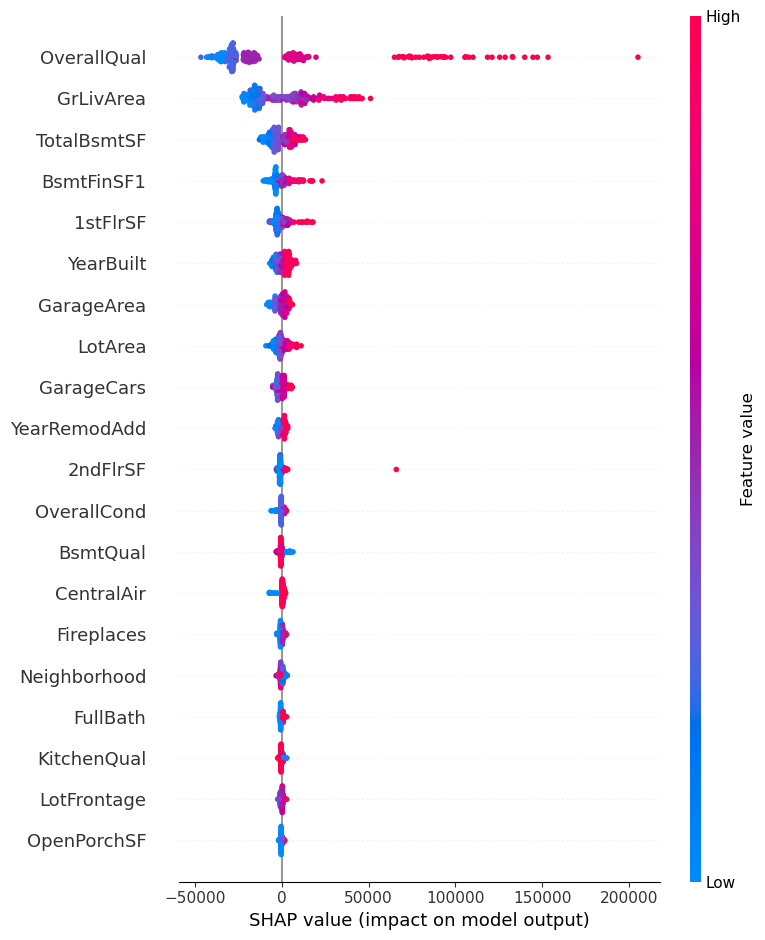

SHAP 方法選出的前 8 大特徵：
Index(['OverallQual', 'GrLivArea', 'TotalBsmtSF', 'BsmtFinSF1', '1stFlrSF',
       'YearBuilt', 'GarageArea', 'LotArea'],
      dtype='object')


In [83]:
import shap

# 計算 SHAP 值
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test)

# 繪製 SHAP Summary Plot
shap.summary_plot(shap_values, X_test)

# 找出前 8 大 SHAP 影響力特徵
shap_importance = np.abs(shap_values).mean(axis=0)
shap_features = X_test.columns[np.argsort(-shap_importance)[:8]]

print("SHAP 方法選出的前 8 大特徵：")
print(shap_features)

In [85]:
# 取得隨機森林內部特徵重要性
rf_importance = rf_model.feature_importances_

# 找出前 8 大特徵
rf_features = X_test.columns[np.argsort(-rf_importance)[:8]]

print("隨機森林內部機制選出的前 8 大特徵：")
print(rf_features)

隨機森林內部機制選出的前 8 大特徵：
Index(['OverallQual', 'GrLivArea', 'TotalBsmtSF', '2ndFlrSF', 'BsmtFinSF1',
       '1stFlrSF', 'LotArea', 'GarageArea'],
      dtype='object')


In [87]:
# PFI 選出的特徵
pfi_features = ['OverallQual', 'GrLivArea', '2ndFlrSF', 'TotalBsmtSF', '1stFlrSF',
       'BsmtFinSF1', 'GarageCars', 'LotArea']

# SHAP 選出的特徵
shap_features = ['OverallQual', 'GrLivArea', 'TotalBsmtSF', 'BsmtFinSF1', '1stFlrSF',
       'YearBuilt', 'GarageArea', 'LotArea']

# 隨機森林內部機制選出的特徵
rf_features = ['OverallQual', 'GrLivArea', 'TotalBsmtSF', '2ndFlrSF', 'BsmtFinSF1',
               '1stFlrSF', 'LotArea', 'GarageArea']

In [89]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# 設定相同的模型參數
rf_model = RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42)

def evaluate_model(feature_set, X_train, X_test, y_train, y_test, method_name):
    # 選擇特定的特徵
    X_train_selected = X_train[feature_set]
    X_test_selected = X_test[feature_set]
    
    # 訓練模型
    rf_model.fit(X_train_selected, y_train)
    y_pred = rf_model.predict(X_test_selected)
    
    # 計算評估指標
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f"=== {method_name} 選出的特徵 ===")
    print(f"MSE: {mse:.5f}")
    print(f"RMSE: {rmse:.5f}")
    print(f"MAE: {mae:.5f}")
    print(f"R² Score: {r2:.5f}")
    print("\n")
    
    return mse, rmse, mae, r2

# 執行實驗
results = {}
results['PFI'] = evaluate_model(pfi_features, X_train, X_test, y_train, y_test, "PFI")
results['SHAP'] = evaluate_model(shap_features, X_train, X_test, y_train, y_test, "SHAP")
results['Random Forest'] = evaluate_model(rf_features, X_train, X_test, y_train, y_test, "Random Forest")

=== PFI 選出的特徵 ===
MSE: 820934683.20276
RMSE: 28651.95776
MAE: 19267.88580
R² Score: 0.89297


=== SHAP 選出的特徵 ===
MSE: 884679255.55971
RMSE: 29743.55822
MAE: 18899.31115
R² Score: 0.88466


=== Random Forest 選出的特徵 ===
MSE: 859550842.10942
RMSE: 29318.09752
MAE: 19133.55159
R² Score: 0.88794




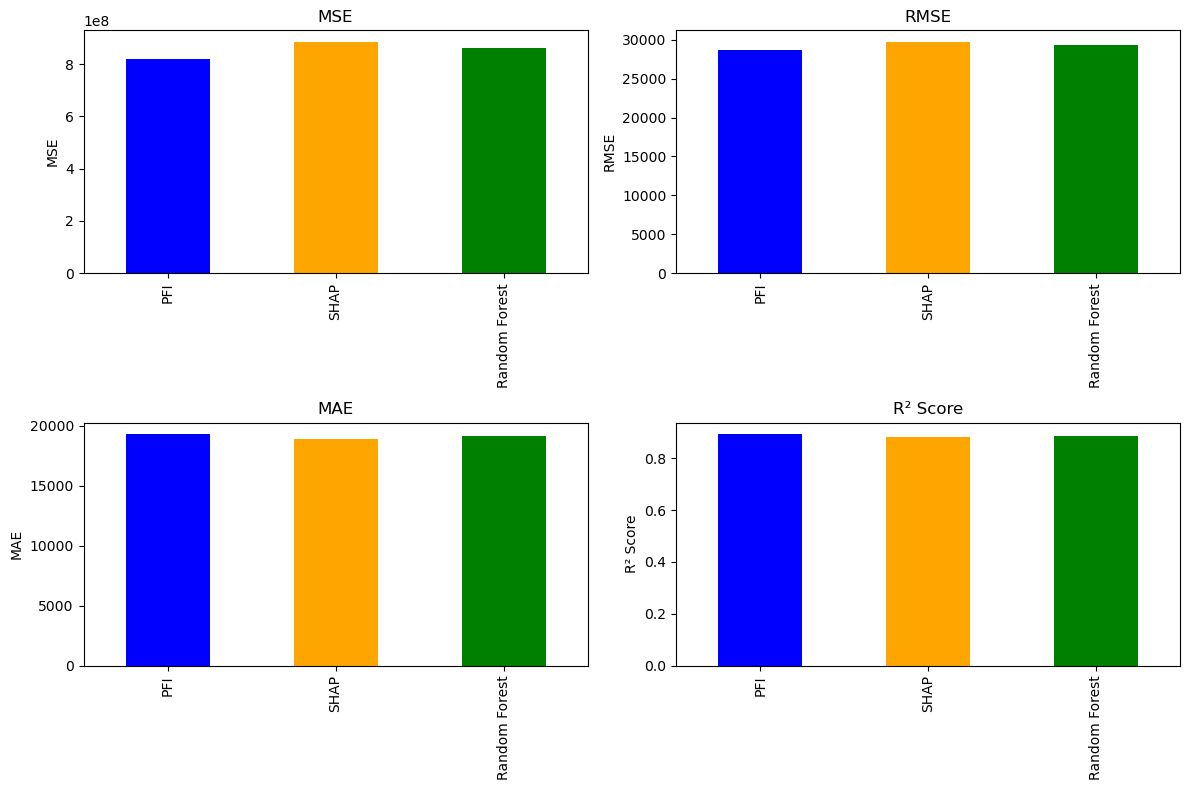

In [95]:
import pandas as pd
import matplotlib.pyplot as plt

# 將 results 轉換為 DataFrame
df_results = pd.DataFrame(results, index=["MSE", "RMSE", "MAE", "R² Score"])

# 畫圖
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

metrics = ["MSE", "RMSE", "MAE", "R² Score"]
for i, metric in enumerate(metrics):
    ax = axes[i//2, i%2]
    df_results.loc[metric].plot(kind='bar', ax=ax, title=metric, color=['blue', 'orange', 'green'])
    ax.set_ylabel(metric)

plt.tight_layout()
plt.show()

/Users/ccit0915/anaconda3/lib/python3.11/site-packages/matplotlib_venn/layout/venn3/pairwise.py:169: UserWarning: Bad circle positioning.
  warnings.warn("Bad circle positioning.")


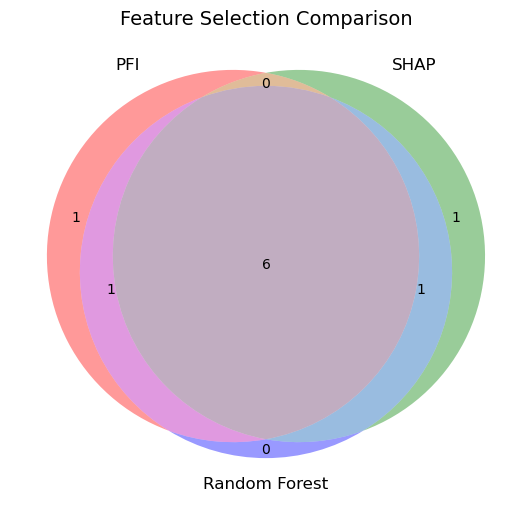

In [99]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn3

# 定義三組特徵（轉換為 set）
pfi_features = {'OverallQual', 'GrLivArea', '2ndFlrSF', 'TotalBsmtSF', '1stFlrSF',
                'BsmtFinSF1', 'GarageCars', 'LotArea'}

shap_features = {'OverallQual', 'GrLivArea', 'TotalBsmtSF', 'BsmtFinSF1', '1stFlrSF',
                 'YearBuilt', 'GarageArea', 'LotArea'}

rf_features = {'OverallQual', 'GrLivArea', 'TotalBsmtSF', '2ndFlrSF', 'BsmtFinSF1',
               '1stFlrSF', 'LotArea', 'GarageArea'}

# 繪製 Venn 圖
plt.figure(figsize=(8, 6))
venn = venn3([pfi_features, shap_features, rf_features],
             set_labels=('PFI', 'SHAP', 'Random Forest'))

# 設定標籤字體大小
for subset in venn.set_labels:
    subset.set_fontsize(12)

plt.title("Feature Selection Comparison", fontsize=14)
plt.show()

In [101]:
# 三者皆選出的特徵
common_all = pfi_features & shap_features & rf_features

# 任意兩者交集
common_pfi_shap = pfi_features & shap_features
common_pfi_rf = pfi_features & rf_features
common_shap_rf = shap_features & rf_features

# 僅被單一方法選出的特徵
only_pfi = pfi_features - (shap_features | rf_features)
only_shap = shap_features - (pfi_features | rf_features)
only_rf = rf_features - (pfi_features | shap_features)

# 輸出結果
print("=== 三者皆選出的特徵 ===")
print(common_all)

print("\n=== PFI & SHAP 交集（但不包含 RF）===")
print(common_pfi_shap - common_all)

print("\n=== PFI & RF 交集（但不包含 SHAP）===")
print(common_pfi_rf - common_all)

print("\n=== SHAP & RF 交集（但不包含 PFI）===")
print(common_shap_rf - common_all)

print("\n=== 只有 PFI 選出的特徵 ===")
print(only_pfi)

print("\n=== 只有 SHAP 選出的特徵 ===")
print(only_shap)

print("\n=== 只有 RF 選出的特徵 ===")
print(only_rf)

=== 三者皆選出的特徵 ===
{'GrLivArea', 'TotalBsmtSF', 'BsmtFinSF1', '1stFlrSF', 'OverallQual', 'LotArea'}

=== PFI & SHAP 交集（但不包含 RF）===
set()

=== PFI & RF 交集（但不包含 SHAP）===
{'2ndFlrSF'}

=== SHAP & RF 交集（但不包含 PFI）===
{'GarageArea'}

=== 只有 PFI 選出的特徵 ===
{'GarageCars'}

=== 只有 SHAP 選出的特徵 ===
{'YearBuilt'}

=== 只有 RF 選出的特徵 ===
set()


In [121]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import pandas as pd

# 選擇 8 個特徵
selected_features_8 = ['GrLivArea', 'TotalBsmtSF', 'BsmtFinSF1', '1stFlrSF', 'OverallQual', 'LotArea','GarageCars','YearBuilt']

# 取出這些特徵
X_train_selected_8 = X_train[selected_features_8]
X_test_selected_8 = X_test[selected_features_8]

# 建立隨機森林模型
rf_model_selected_8 = RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42)
rf_model_selected_8.fit(X_train_selected_8, y_train)

# 預測測試集
y_pred_selected_8 = rf_model_selected_8.predict(X_test_selected_8)  # 修正這裡的變數名稱

# 計算評估指標
mse_selected_8 = mean_squared_error(y_test, y_pred_selected_8)
rmse_selected_8 = np.sqrt(mse_selected_8)
mae_selected_8 = mean_absolute_error(y_test, y_pred_selected_8)
r2_selected_8 = r2_score(y_test, y_pred_selected_8)

# 輸出評估指標
print("selected_features_8 各項指標")
print(f"測試 MSE: {mse_selected_8}")
print(f"測試 RMSE: {rmse_selected_8}")
print(f"測試 MAE: {mae_selected_8}")
print(f"測試 R²: {r2_selected_8}")

selected_features_8 各項指標
測試 MSE: 813757358.1853704
測試 RMSE: 28526.43262283895
測試 MAE: 18629.94227943462
測試 R²: 0.8939083767489736


/Users/ccit0915/anaconda3/lib/python3.11/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
/Users/ccit0915/anaconda3/lib/python3.11/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
/Users/ccit0915/anaconda3/lib/python3.11/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


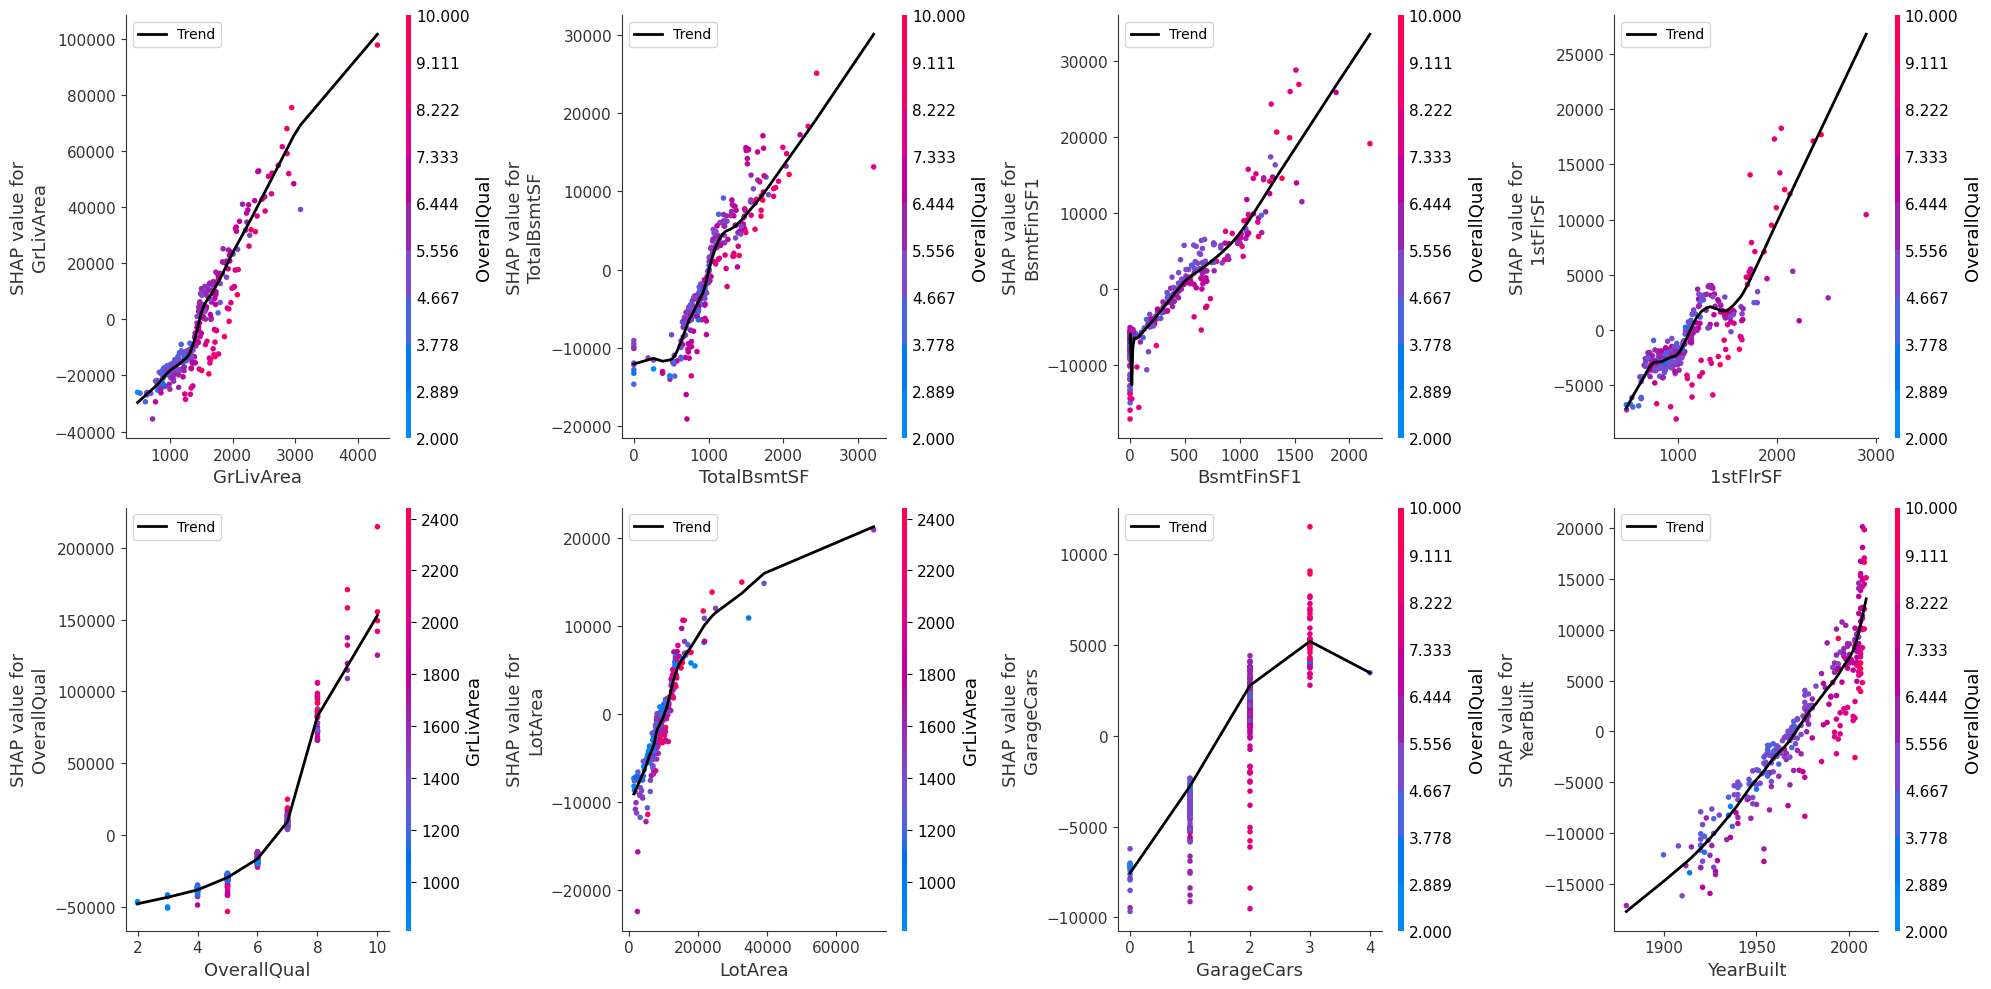

In [123]:
import shap
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm  # 用於 LOESS 曲線擬合

# **新 8 個最佳特徵**
selected_features_8 = [
    'GrLivArea', 'TotalBsmtSF', 'BsmtFinSF1', '1stFlrSF', 'OverallQual', 'LotArea','GarageCars','YearBuilt'
]

# 計算 SHAP 值
explainer = shap.TreeExplainer(rf_model_selected_8)  # 確保使用的是新模型
shap_values = explainer.shap_values(X_test[selected_features_8])  

# **創建 2x4 子圖**
fig, axes = plt.subplots(2, 4, figsize=(20, 10))  

# **逐個繪製 SHAP 依賴圖**
for i, feature in enumerate(selected_features_8):
    ax = axes[i // 4, i % 4]  # 設定子圖位置
    
    # 繪製 SHAP 依賴圖（不自動顯示）
    shap.dependence_plot(feature, shap_values, X_test[selected_features_8], ax=ax, show=False)
    
    # 取得該特徵的數據 & SHAP 值
    feature_values = X_test[feature].values
    shap_values_feature = shap_values[:, i]

    # **只對數值型變數繪製 LOESS 平滑曲線**
    if X_test[feature].dtype in [np.float64, np.int64]:
        # LOESS 擬合 (frac 控制平滑程度，通常 0.2~0.3)
        smoothed = sm.nonparametric.lowess(shap_values_feature, feature_values, frac=0.3)
        ax.plot(smoothed[:, 0], smoothed[:, 1], color='black', linewidth=2, label="Trend")

    ax.legend()  # 顯示圖例

plt.tight_layout()  # 自動調整子圖間距
plt.show()  # 顯示圖像

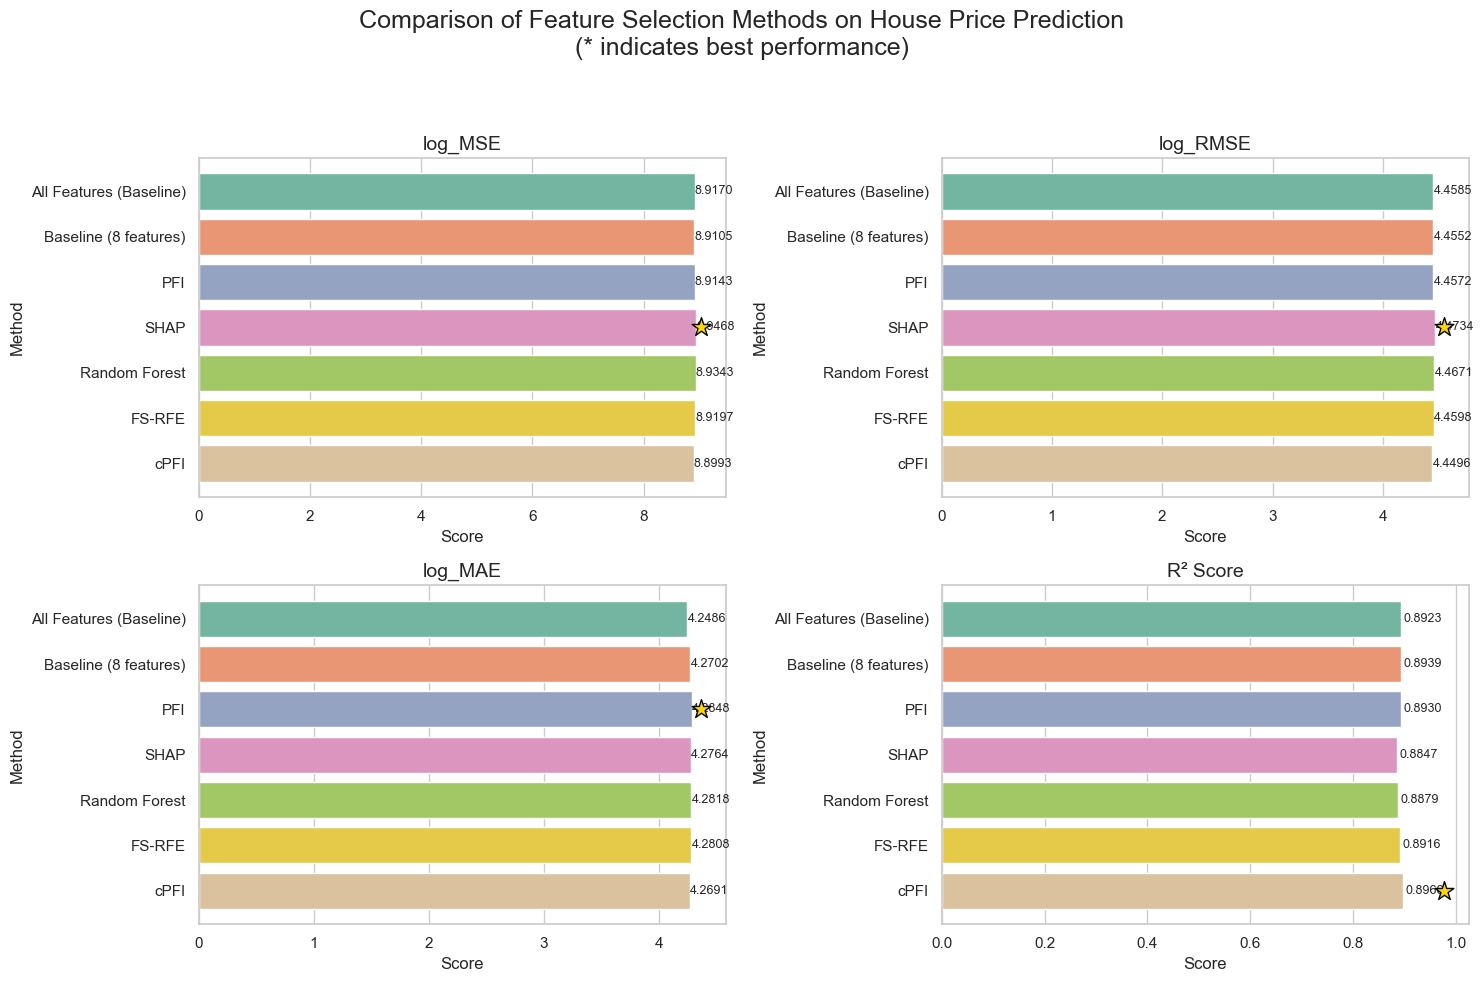

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 建立資料
data = {
    'Method': [
        'All Features (Baseline)', 'Baseline (8 features)', 
        'PFI', 'SHAP', 'Random Forest', 'FS-RFE', 'cPFI'
    ],
    'MSE': [826011126.0808233, 813757358.1853704, 820934683.20276, 884679255.55971, 859550842.10942, 831159261.9555, 792968787.9117],
    'RMSE': [28740.409288679646, 28526.43262283895, 28651.95776, 29743.55822, 29318.09752, 28829.8328, 28159.7015],
    'MAE': [17724.71112435259, 18629.94227943462, 19267.88580, 18899.31115, 19133.55159, 19090.2232, 18580.7955],
    'R² Score': [0.8923108217605077, 0.8939083767489736, 0.89297, 0.88466, 0.88794, 0.8916, 0.8966]
}

df = pd.DataFrame(data)

# 對 MSE、RMSE、MAE 進行對數轉換
df['log_MSE'] = np.log10(df['MSE'])
df['log_RMSE'] = np.log10(df['RMSE'])
df['log_MAE'] = np.log10(df['MAE'])

# 將資料轉換為長格式
df_melted = df.melt(id_vars='Method', var_name='Metric', value_name='Score')

# 找出每個指標的最佳值
best_scores = df_melted.groupby('Metric')['Score'].max().to_dict()

# 畫圖
sns.set(style="whitegrid")
metrics = ['log_MSE', 'log_RMSE', 'log_MAE', 'R² Score']
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for i, metric in enumerate(metrics):
    metric_df = df_melted[df_melted['Metric'] == metric]
    ax = axes[i]
    bars = sns.barplot(
        data=metric_df, x='Score', y='Method',
        hue='Method',  # 為了配合 palette
        palette='Set2',
        legend=False,  # 不顯示圖例，避免重複
        ax=ax
    )
    ax.set_title(metric, fontsize=14)

    for j, p in enumerate(ax.patches):
        score = p.get_width()
        method = metric_df.iloc[j]['Method']

        # 顯示數值
        ax.text(score + 0.005, p.get_y() + p.get_height() / 2,
                f'{score:.4f}', va='center', fontsize=9)

        # 如果是最佳值，加上星星（scatter marker='*'）
        if round(score, 4) == round(best_scores[metric], 4):
            ax.scatter(score + 0.08, p.get_y() + p.get_height() / 2,
                       color='gold', marker='*', s=200, edgecolor='black', zorder=5)

plt.suptitle('Comparison of Feature Selection Methods on House Price Prediction\n(* indicates best performance)', fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.94])
plt.show()